In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
%config InlineBackend.figure_format = 'retina'
import random
import os
import seaborn as sns
#import lal
from scipy.interpolate import interp1d
#sns.set(rc={'figure.figsize':(11.7,8.27)})

from scipy.stats import beta
from scipy.stats import lognorm

import matplotlib.mlab as mlab

cp=sns.color_palette('Dark2', 20)
#sns.set_context('notebook')
#sns.set(style="white", palette="muted")
from scipy import stats
import get_wavelet_params as wp
from matplotlib import rc

rc('text', usetex=True)

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

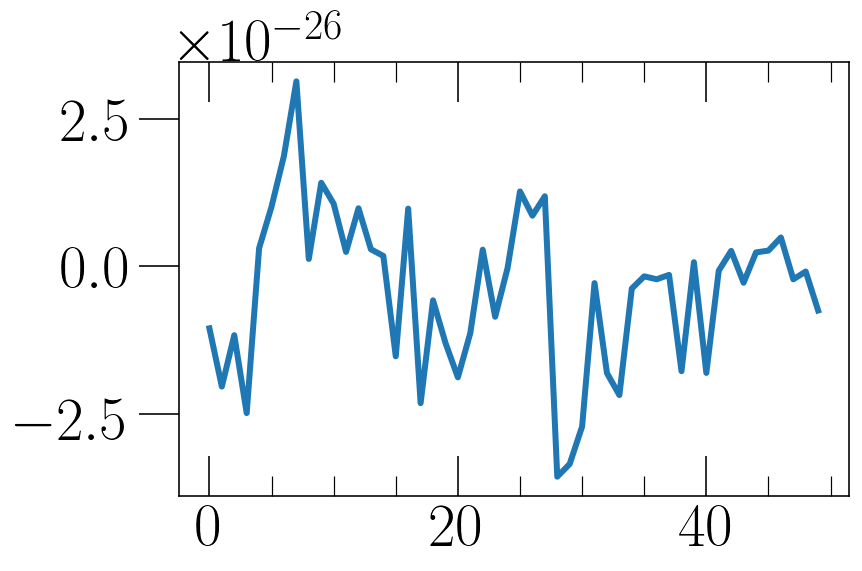

In [17]:
plt.figure()
data = np.loadtxt("/home/maria.okounkova/BeyondGRAnalysis/Waveforms/dCS_0p0/dCS_0p0_SNR_150/trigtime_1197495364.000000000_0.0_0.0_0/post/signal/signal_recovered_colored_waveform_L1.dat", \
                 comments="#",usecols=([0]),unpack=True)
plt.plot(data)
plt.show()

2.4722718157420245e-21
2.4761549969255234e-21


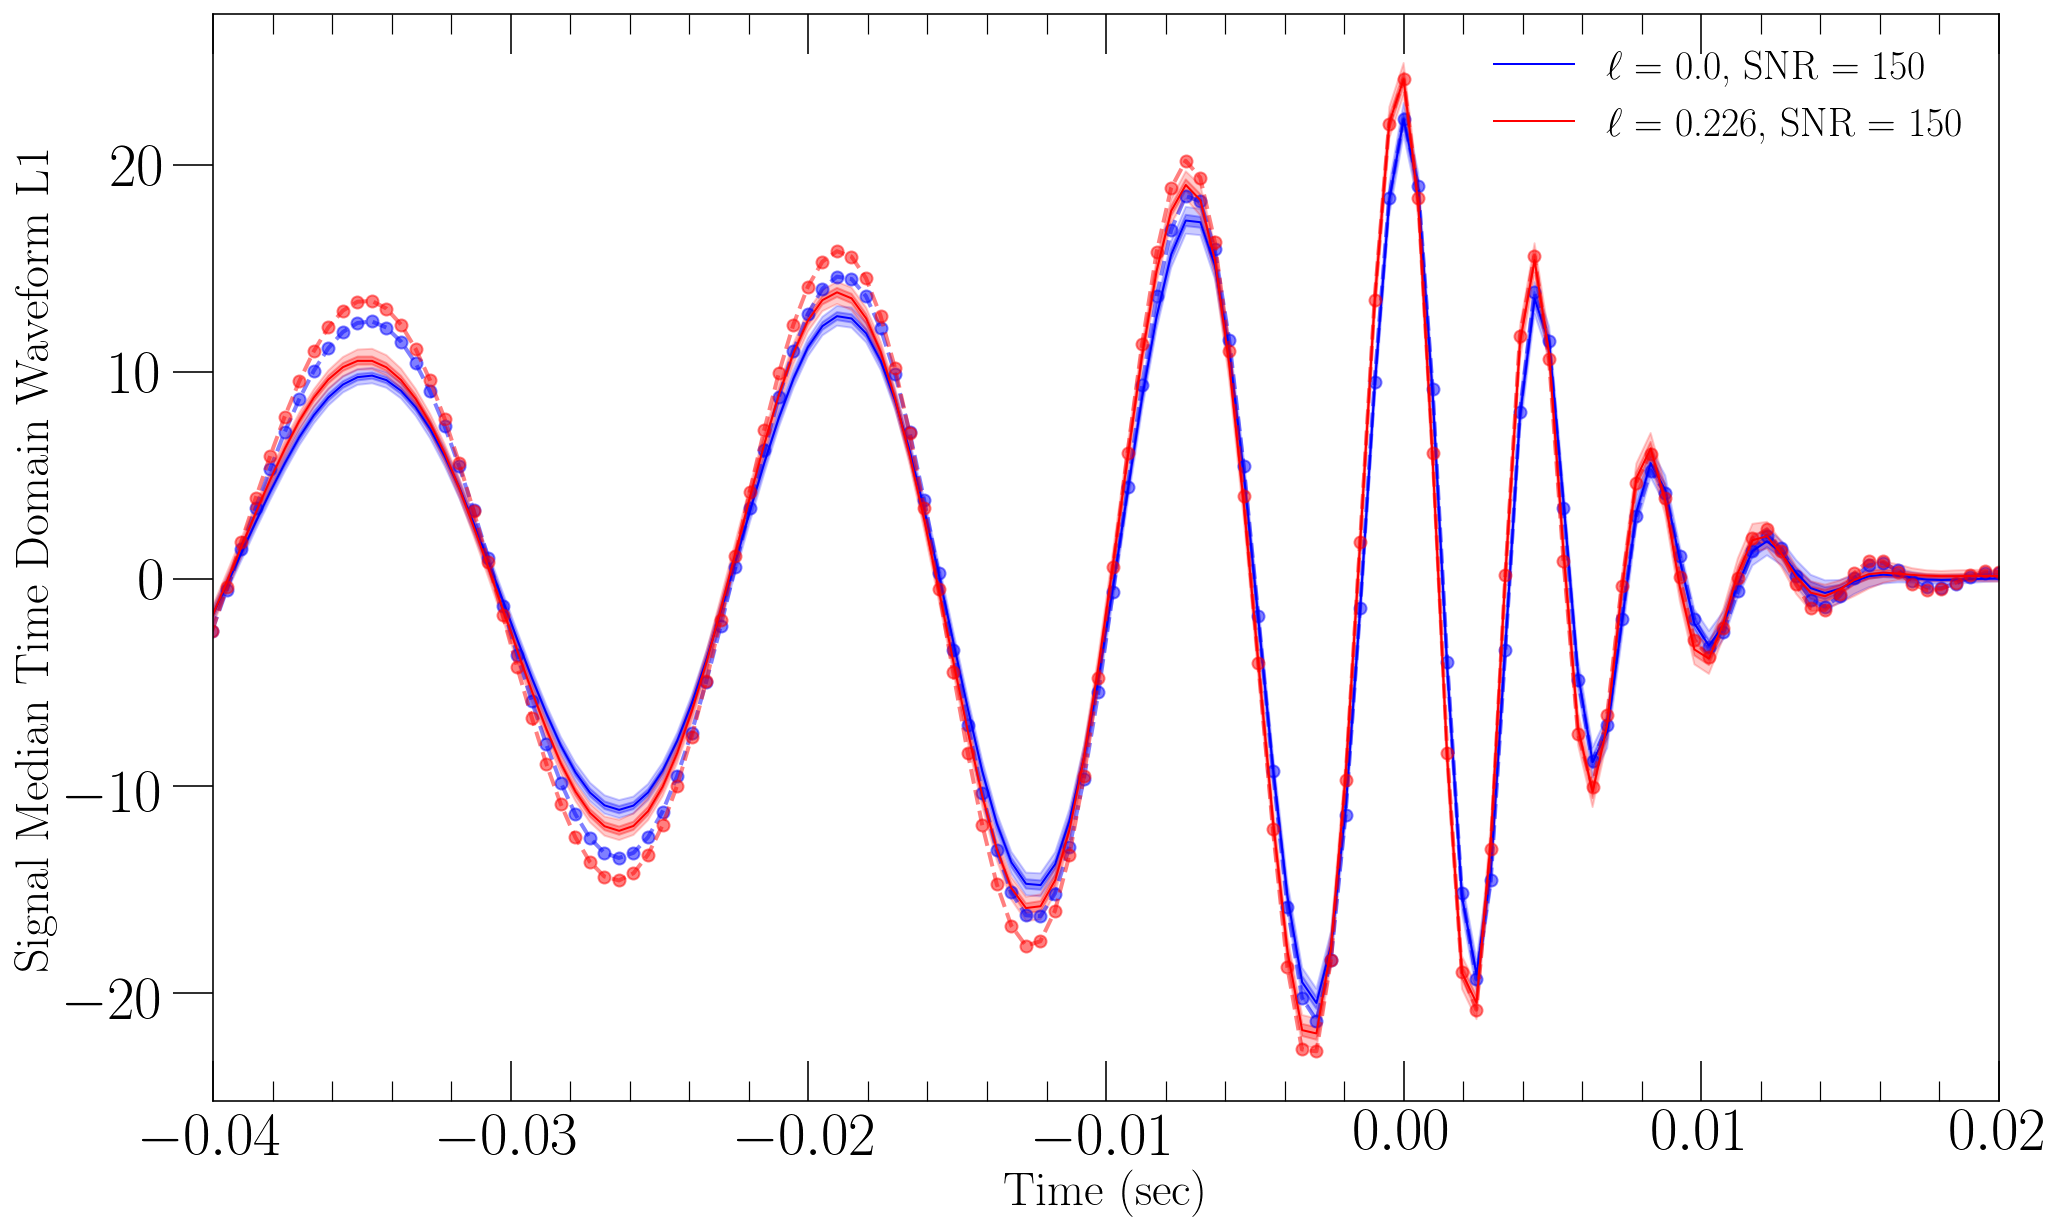

In [34]:
def GetMedianData(ell, SNR):
    """ Given a coupling constant value and an SNR, return the columns of the median waveform data """
    
    ell = str(ell).replace('.','p')
    SNR = str(SNR)
    #base_dir = "/home/maria.okounkova/BeyondGRAnalysis/Waveforms/dCS_" + ell + \
    #           "/dCS_" + ell + "_SNR_" + SNR + "/trigtime_1197495364.000000000_0.0_0.0_0/post/signal/"
    base_dir = "/home/maria.okounkova/public_html/dCS_" + ell + "_SNR_" + SNR \
               + "/trigtime_1197495364.000000000_0.0_0.0_0/post/signal/"
    ## Grab Livingston data
    f = base_dir + "signal_median_time_domain_waveform_L1.dat"
    time, d1, d2, d3, d4, d5 = np.loadtxt(f, comments="#",usecols=([0,1,2,3,4,5]),unpack=True)
    
    ## Subtract peak time
    t_peak = time[np.argmax(np.abs(d1))]
    time = time - t_peak
    
    return time, d1, d2, d3, d4, d5


def GetInjectedData(ell, SNR):
    ell = str(ell).replace('.','p')
    SNR = str(SNR)
    f = "/home/maria.okounkova/BeyondGRAnalysis/Waveforms/dCS_" + ell + "/" \
               + "hwinjcbc_1197495358_dCS_" + ell + "_SNR_" + SNR + "_L1.txt"
    data = np.loadtxt(f, comments="#",usecols=([0]),unpack=True)
    s_rate = 2048 # Hz
    dt = 1.0/s_rate
    time = np.array([dt * t for t in range(len(data))])
    t_peak = time[np.argmax(np.abs(data))]
    time = time - t_peak
    print(max(data))
    return time, data
    
def PlotMedianData(ell, SNR, c):
    time, d1, d2, d3, d4, d5 = GetMedianData(ell, SNR)
    plt.plot(time, d1, lw = 1.0, alpha = 1.0, c=c, label=r'$\ell$ = ' + str(ell) + ', SNR = ' + str(SNR))
    plt.fill_between(time, d2, d3, alpha = 0.3, color=c, edgecolor=None)
    plt.fill_between(time, d4, d5, alpha = 0.2, color=c, edgecolor=None)
    time, data = GetInjectedData(ell, SNR)
    factor = np.max(np.abs(data))/np.max(np.abs(d1))
    plt.plot(time, data/factor, '--o', color=c, lw = 2.0, alpha=0.5)

plt.figure(figsize=(16,10))

PlotMedianData(0.0, 150, 'blue')
#PlotMedianData(0.1, 150, 'orange')
PlotMedianData(0.226, 150, 'red')

plt.legend(frameon=False, fontsize=20)
plt.xlim(-0.04, 0.02)
plt.xlabel('Time (sec)')
plt.ylabel('Signal Median Time Domain Waveform L1')
plt.savefig('Medians.pdf')


plt.show()



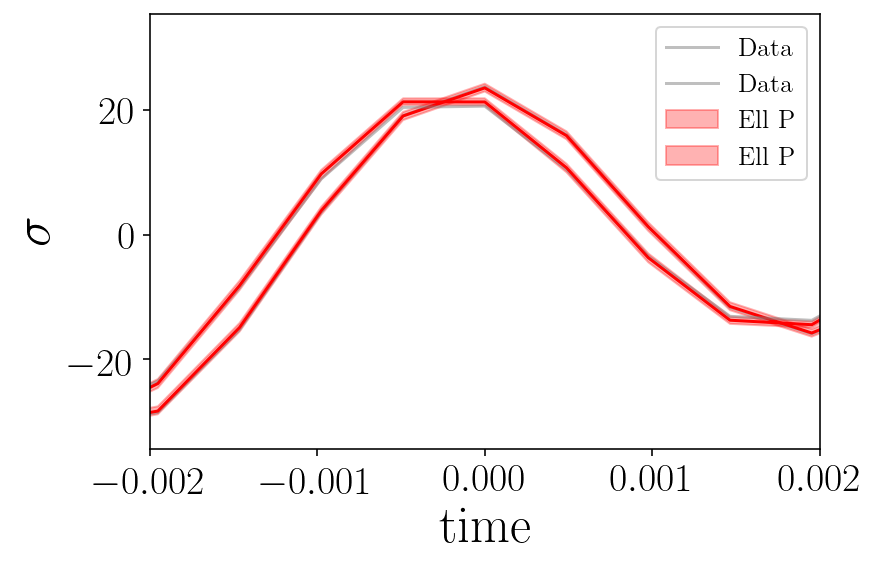

In [34]:
Data0p0=np.genfromtxt("Run/SNR250/dCS_0p0/waveforms/signal_data_H1_0.dat")
Data0p226=np.genfromtxt("Run/SNR250/dCS_0p226/waveforms/signal_data_H1_0.dat")

N=200-10
Wave0p0=[]
Wave0p226=[]
for i in range(N):
    Wave0p0.append(np.genfromtxt("Run/SNR250/dCS_0p0/waveforms/signal_wave_H1_%s.dat"%str(i+10)))
    Wave0p226.append(np.genfromtxt("Run/SNR250/dCS_0p226/waveforms/signal_wave_H1_%s.dat"%str(i+10)))
    
fig = plt.figure()
PlotMedianWaveform(Data0p0,Wave0p0)
PlotMedianWaveform(Data0p226,Wave0p226)
plt.xlim(-0.002,0.002)
plt.show()
#fig.savefig("GW150914_EllPolarization_reconstruction.pdf",bbox_inches='tight')

In [19]:
PSD=np.genfromtxt("PSD/aligo_O2_psd.dat")

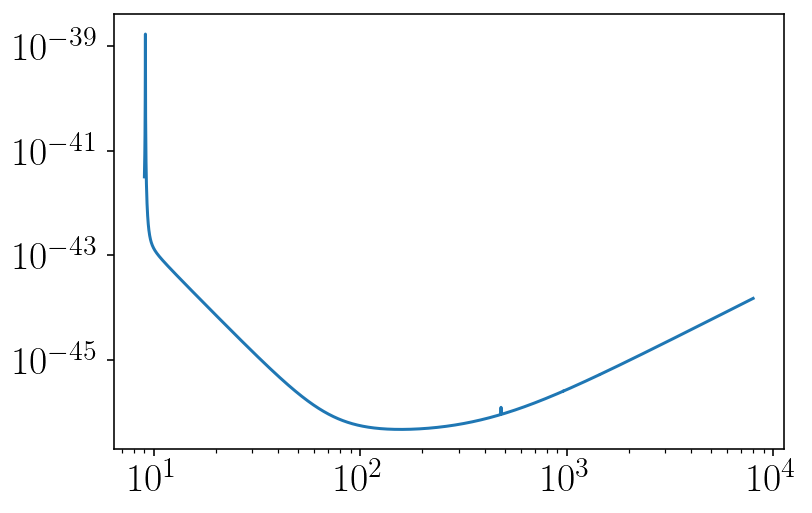

In [23]:
plt.plot(PSD[:,0],PSD[:,1])
plt.yscale('log')
plt.xscale('log')
plt.show()

In [26]:
with open('PSD/aligo_O2_psd_times10.dat', 'w') as f:
    for i in range(len(PSD)):
        f.write("%g %g\n" % (PSD[:,0][i],PSD[:,1][i]*0.01))